# ML comparisons

In [5]:
import pandas as pd
from remseno import *

data_dir = '../data/harvard/'

neon_gold_df = pd.read_csv(f'{data_dir}training_pixels_neon_validation_nn.csv')
tallo_training_df = pd.read_csv(f'{data_dir}training_pixels_tallo_neon_nn.csv')
print("Shared species:", set(neon_gold_df.species) & set(tallo_training_df.species))

Shared species: {'Populus tremuloides', 'Acer rubrum', 'Pinus palustris', 'Liquidambar styraciflua', 'Quercus stellata', 'Quercus rubra', 'Tsuga canadensis', 'Metrosideros polymorpha', 'Pinus contorta', 'Tsuga heterophylla', 'Picea engelmannii', 'Quercus alba', 'Abies balsamea', 'Pseudotsuga menziesii', 'Acer saccharum', 'Abies lasiocarpa'}


# Filter the datasets to only include the shared species

In [7]:
u = SciUtil()
shared_species = set(neon_gold_df.species) & set(tallo_training_df.species)
tallo_training_df = tallo_training_df[tallo_training_df.species.isin(shared_species)]
neon_gold_df = neon_gold_df[neon_gold_df.species.isin(shared_species)]

# Print the value counts of both
u.dp(['Tallo Training: '])
print(tallo_training_df.species.value_counts())

u.dp(['Neon Validation: '])
print(neon_gold_df.species.value_counts())

# Make a training sample that is a subsample with "even" classes
max_sample = 1000
train_df = pd.DataFrame()# Get a random sample which is even between each species

for species in set(tallo_training_df['species'].values):
    s_df = tallo_training_df[tallo_training_df['species'] == species]
    train_df = pd.concat([train_df, s_df.sample(min(1000, len(s_df)))])


--------------------------------------------------------------------------------
                               Tallo Training: 	                                
--------------------------------------------------------------------------------
species
Tsuga heterophylla         60574
Acer saccharum             26943
Abies balsamea             24590
Pseudotsuga menziesii      23346
Populus tremuloides        22763
Tsuga canadensis           18819
Pinus contorta             11264
Acer rubrum                 7406
Quercus rubra               6872
Quercus alba                4060
Liquidambar styraciflua     2791
Picea engelmannii           1420
Abies lasiocarpa             959
Pinus palustris              797
Quercus stellata             182
Metrosideros polymorpha        2
Name: count, dtype: int64
--------------------------------------------------------------------------------
                               Neon Validation: 	                               
---------------------------------

# Try different classififications using different models and number of class probelms


1. 2 class problem
2. 2 class imbalanced problem
3. 3 class problem
4. 4 class problem
5. All

In [36]:
from remseno import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, balanced_accuracy_score, class_likelihood_ratios, f1_score, precision_score, roc_auc_score, roc_curve
plt.rcParams["figure.figsize"] = (4,4)

    
# Maybe add in https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html#sklearn.metrics.brier_score_loss
def get_scores(y, y_pred, print_scores=True, plot_plots=False):
    scores = {#'average_precision_score': average_precision_score(y, y_pred), 
              'balanced_accuracy_score': balanced_accuracy_score(y, y_pred),
              #'class_likelihood_ratios': class_likelihood_ratios(y, y_pred),
              #'f1_score': f1_score(y, y_pred),
              #'precision_score': precision_score(y, y_pred),
              #'recall_score': recall_score(y, y_pred)
             }
#     plots = {'roc_auc_score': roc_auc_score(y, y_pred), 
#              'precision_recall_curve': precision_recall_curve(y, y_pred), # precision, recall, thresholds
#              'roc_curve': roc_curve(y, y_pred)} # fpr, tpr, thresholds
    plot = {}
    for score in scores:
        print(score, scores[score])
    return scores, plot
    
def classify(training_df, training_cols, clf=None, test_percent=30, label='', clf_type='rf'):
    X = training_df[training_cols].values
    X = np.nan_to_num(X)
    min_x = X.min(axis=0)
    max_x = X.max(axis=0)
    mean_x = X.mean(axis=0)
    std_x = X.std(axis=0)
    X = (X - min_x) / (max_x - min_x)
    y = training_df['species']
    if not clf:
        if clf_type == 'rf':
            clf = RandomForestClassifier(max_depth=20, random_state=0)#svm.LinearSVC(multi_class="crammer_singer", class_weight='balanced')
        elif clf_type == 'svm':
            clf = svm.LinearSVC(multi_class="crammer_singer", class_weight='balanced')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percent/100,
                                                            random_state=18)
        # Get the pixels from the orthomosaic
        clf = clf.fit(X_train, y_train)
        # Swap over to have plotting all done with the test set
        X = X_test
        y = y_test
        
    y_pred = clf.predict(X)
    get_scores(y, y_pred)
    cm = confusion_matrix(y, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.title(label)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    return clf

Pinus palustris            40
Pseudotsuga menziesii      40
Acer rubrum                25
Quercus stellata           22
Acer saccharum             17
Quercus rubra              16
Tsuga canadensis           15
Populus tremuloides        15
Tsuga heterophylla         15
Metrosideros polymorpha    13
Pinus contorta             13
Abies balsamea             13
Picea engelmannii          13
Liquidambar styraciflua    12
Quercus alba               12
Abies lasiocarpa           11

balanced_accuracy_score 0.9979253112033195


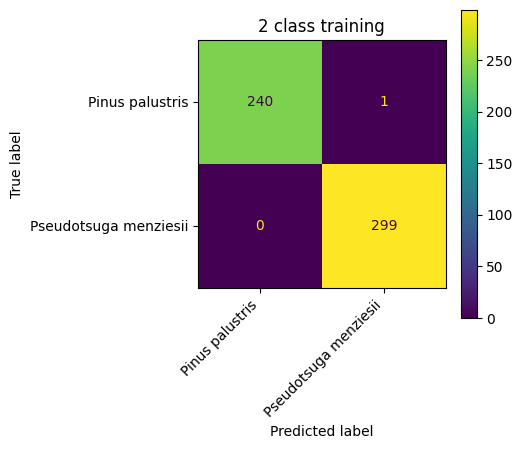

balanced_accuracy_score 0.9


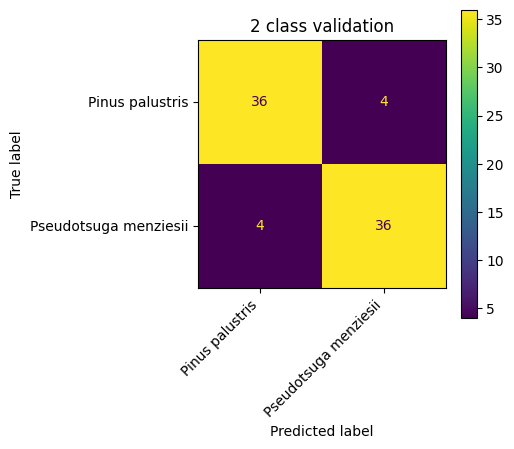

balanced_accuracy_score 0.9887592112019318


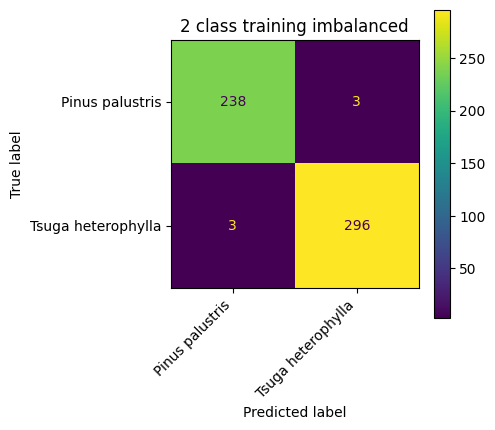

balanced_accuracy_score 0.5


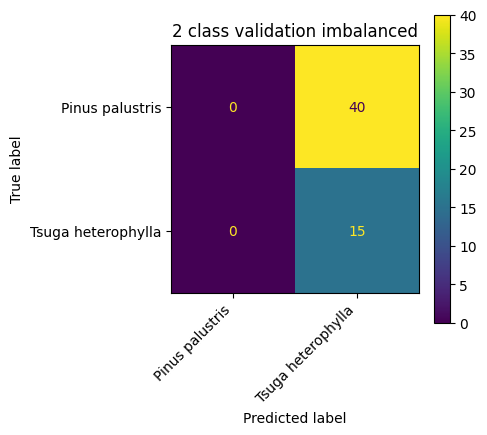

balanced_accuracy_score 0.954593031383239


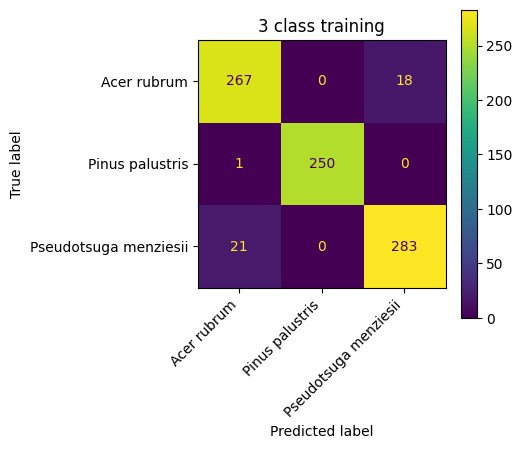

balanced_accuracy_score 0.5633333333333334


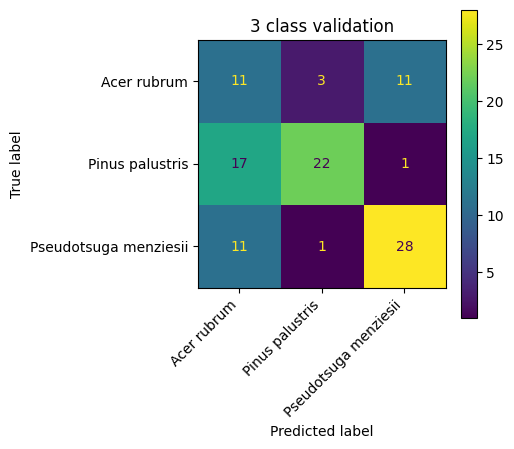

balanced_accuracy_score 0.9304328737323718


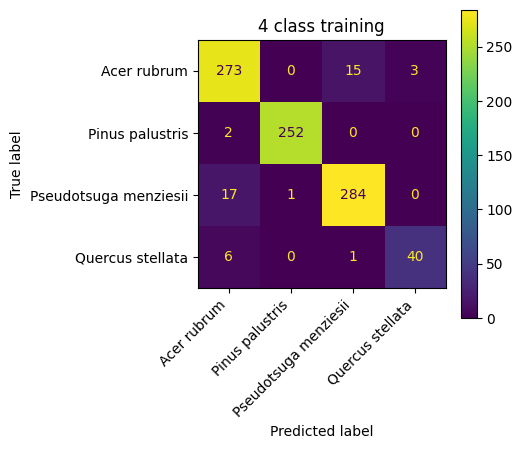

balanced_accuracy_score 0.45875000000000005


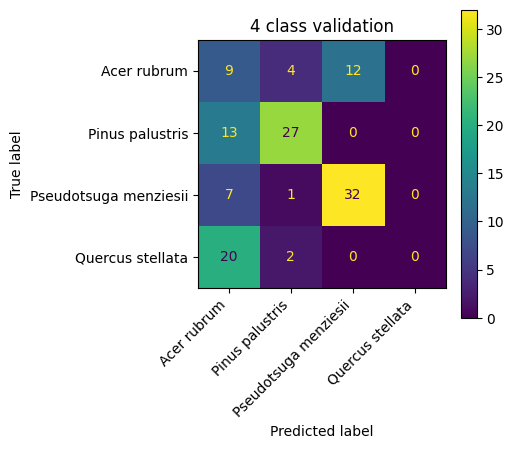

balanced_accuracy_score 0.6771412324144477


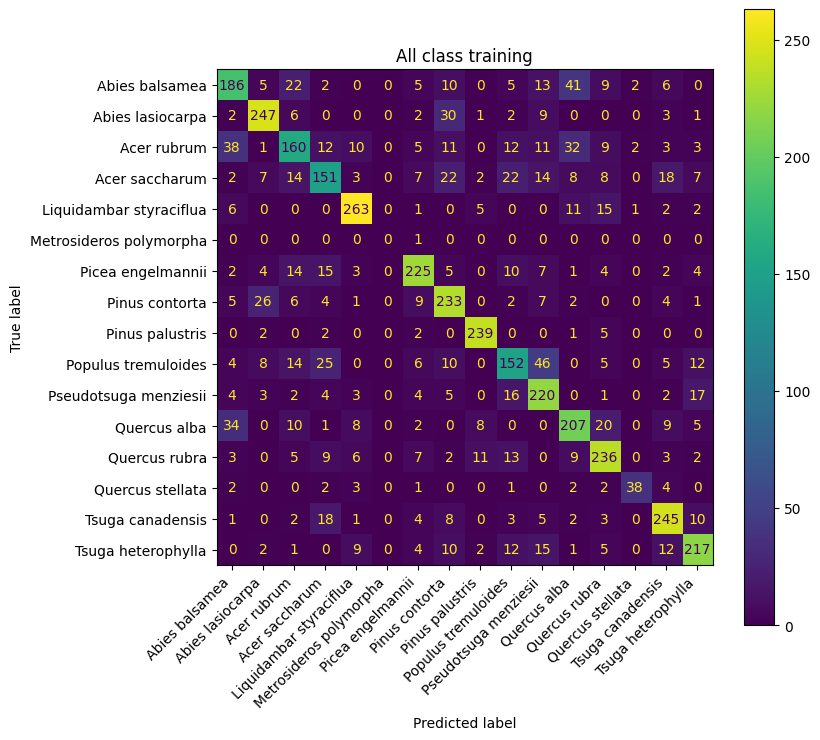

balanced_accuracy_score 0.14795415981077747


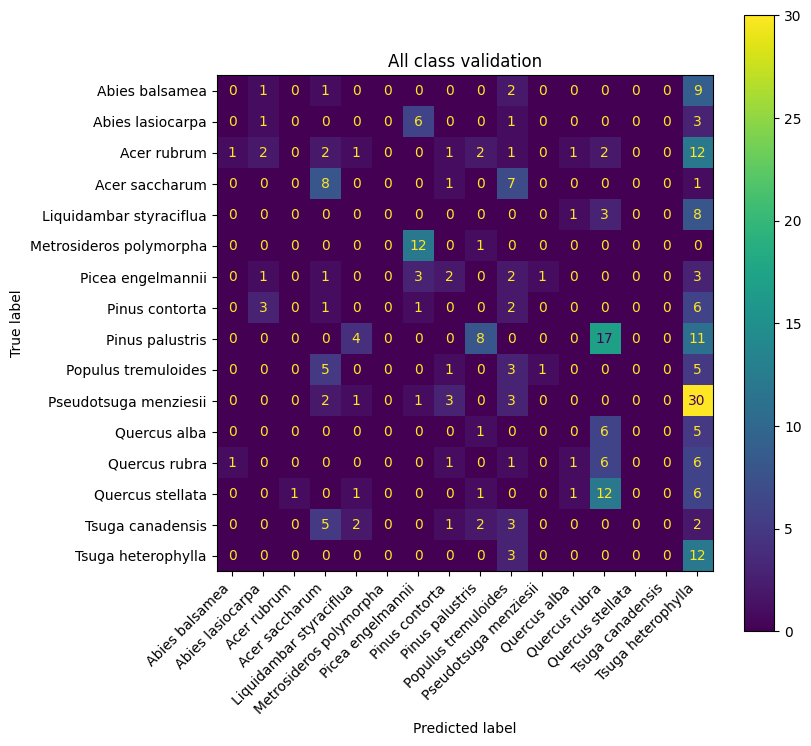

In [35]:
bands = [1, 2, 3, 4, 5, 6, 7, 8]
training_cols = [f'band_{i}' for i in bands] + ['nitian', 'ndvi', 'sr', 'tvi', 'gi', 'gndvi', 'pri', 'osavi', 'tcari', 'redge', 'redge2',
            'siredge', 'normg', 'schl', 'schlcar']

# Run our tests! 
# ---------- 2 class problem with the largest classes in validation
test_species = ['Pinus palustris', 'Pseudotsuga menziesii']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation')

# ---------- 2 class problem with imbalance
test_species = ['Pinus palustris', 'Tsuga heterophylla']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training imbalanced')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation imbalanced')

# ---------- 3 class problem
test_species = ['Pinus palustris', 'Pseudotsuga menziesii', 'Acer rubrum']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='3 class training')
clf = classify(valid_df, training_cols, clf=clf, label='3 class validation')

# ---------- 4 class problem
test_species = ['Pinus palustris', 'Pseudotsuga menziesii', 'Acer rubrum', 'Quercus stellata']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='4 class training')
clf = classify(valid_df, training_cols, clf=clf, label='4 class validation')

plt.rcParams["figure.figsize"] = (8,8)

# ---------- All
training_df = train_df.copy() #[train_df.species.isin(test_species)]
valid_df = neon_gold_df.copy() #[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='All class training')
clf = classify(valid_df, training_cols, clf=clf, label='All class validation')



balanced_accuracy_score 1.0


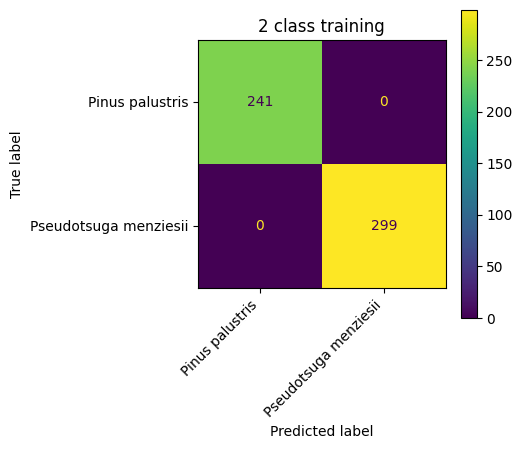

balanced_accuracy_score 0.925


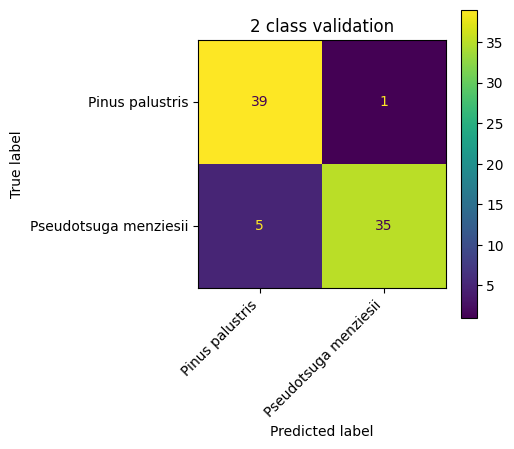

balanced_accuracy_score 0.9787257663858783


/Users/ariane/opt/miniconda3/envs/rhm/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


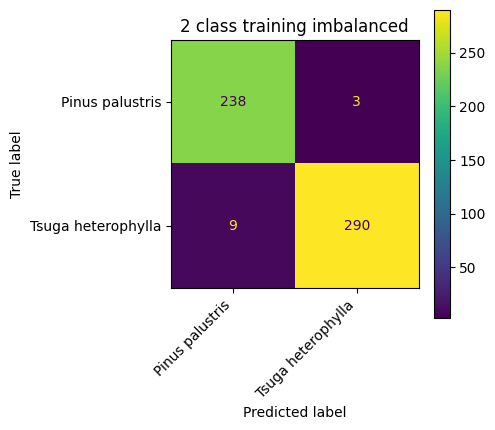

balanced_accuracy_score 1.0


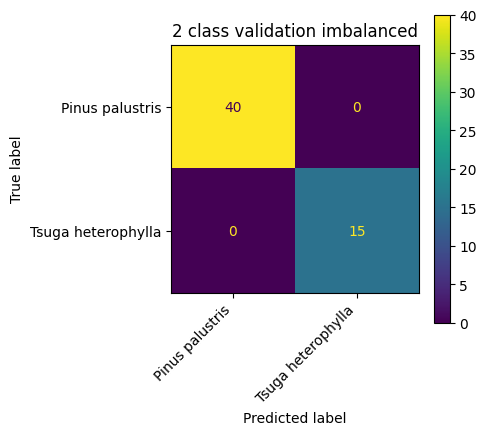

balanced_accuracy_score 0.9134013652990379


/Users/ariane/opt/miniconda3/envs/rhm/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


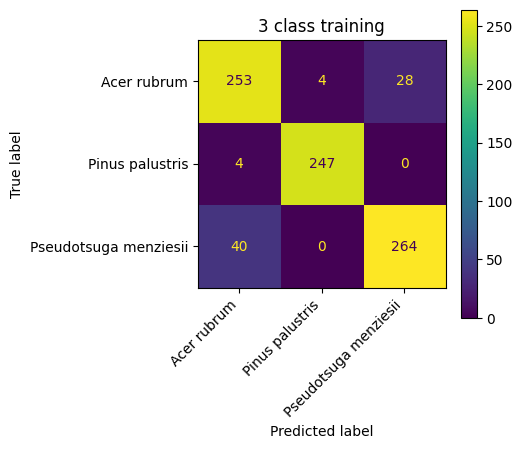

balanced_accuracy_score 0.3466666666666667


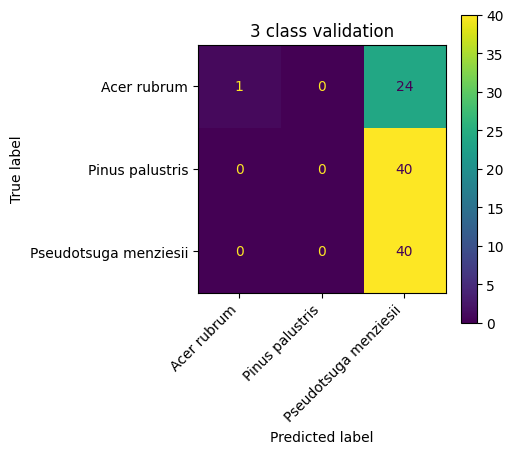

balanced_accuracy_score 0.8399793158807362


/Users/ariane/opt/miniconda3/envs/rhm/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


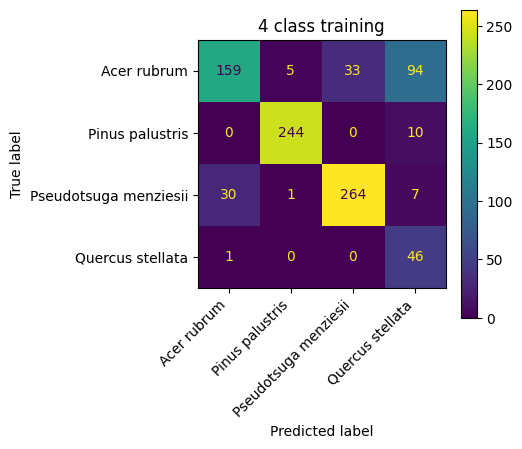

balanced_accuracy_score 0.2827272727272727


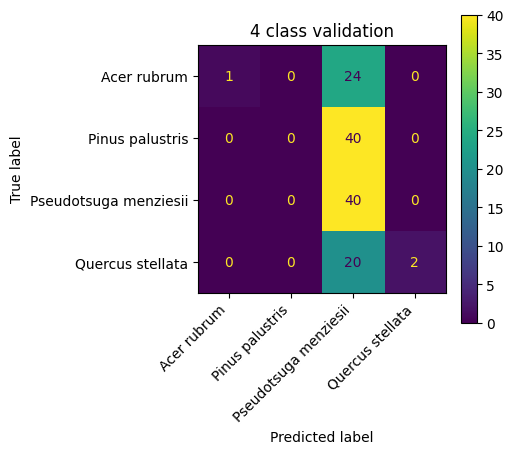

/Users/ariane/opt/miniconda3/envs/rhm/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


balanced_accuracy_score 0.4130745073390799


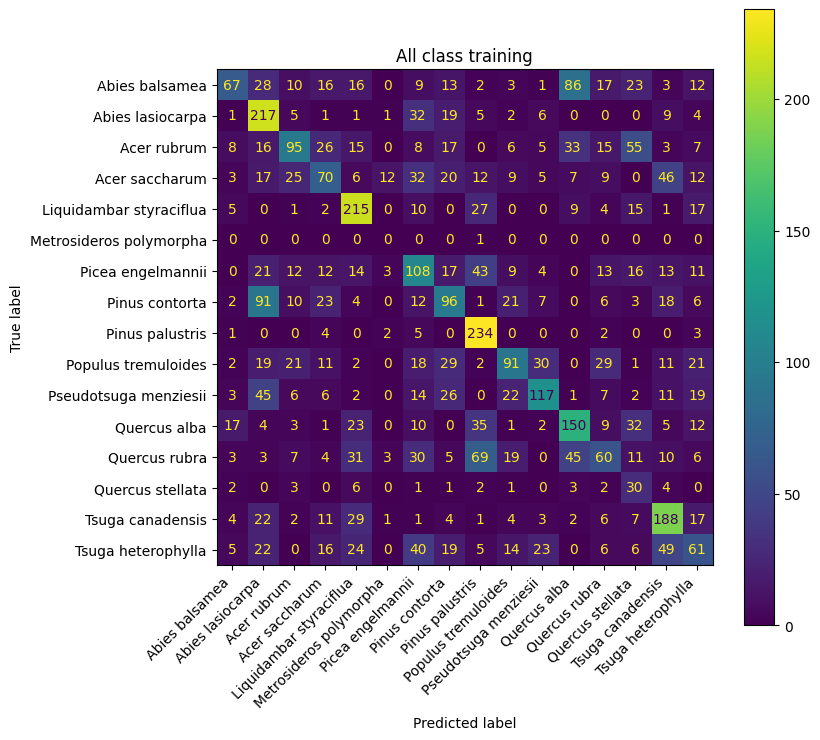

balanced_accuracy_score 0.0625


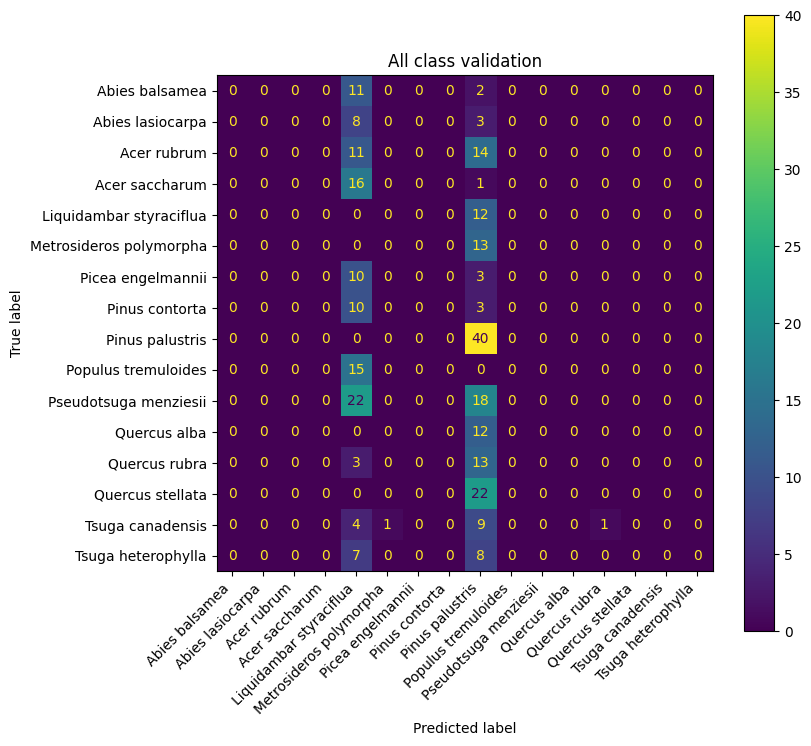

In [37]:
bands = [1, 2, 3, 4, 5, 6, 7, 8]
training_cols = [f'band_{i}' for i in bands] + ['nitian', 'ndvi', 'sr', 'tvi', 'gi', 'gndvi', 'pri', 'osavi', 'tcari', 'redge', 'redge2',
            'siredge', 'normg', 'schl', 'schlcar']

# Run our tests! 
# ---------- 2 class problem with the largest classes in validation
test_species = ['Pinus palustris', 'Pseudotsuga menziesii']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training', clf_type='svm')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation')

# ---------- 2 class problem with imbalance
test_species = ['Pinus palustris', 'Tsuga heterophylla']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training imbalanced', clf_type='svm')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation imbalanced')

# ---------- 3 class problem
test_species = ['Pinus palustris', 'Pseudotsuga menziesii', 'Acer rubrum']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='3 class training', clf_type='svm')
clf = classify(valid_df, training_cols, clf=clf, label='3 class validation')

# ---------- 4 class problem
test_species = ['Pinus palustris', 'Pseudotsuga menziesii', 'Acer rubrum', 'Quercus stellata']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='4 class training', clf_type='svm')
clf = classify(valid_df, training_cols, clf=clf, label='4 class validation')

plt.rcParams["figure.figsize"] = (8,8)

# ---------- All
training_df = train_df.copy() #[train_df.species.isin(test_species)]
valid_df = neon_gold_df.copy() #[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='All class training', clf_type='svm')
clf = classify(valid_df, training_cols, clf=clf, label='All class validation')



Pinus palustris            40
Pseudotsuga menziesii      40
Acer rubrum                25
Quercus stellata           22
Acer saccharum             17
Quercus rubra              16
Tsuga canadensis           15
Populus tremuloides        15
Tsuga heterophylla         15
Metrosideros polymorpha    13
Pinus contorta             13
Abies balsamea             13
Picea engelmannii          13
Liquidambar styraciflua    12
Quercus alba               12
Abies lasiocarpa           11

balanced_accuracy_score 0.8931204926667207


/Users/ariane/opt/miniconda3/envs/rhm/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


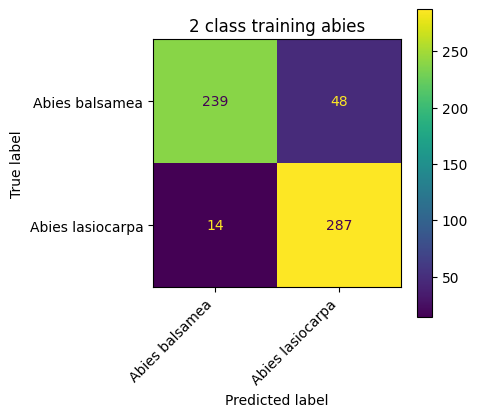

balanced_accuracy_score 0.6958041958041958


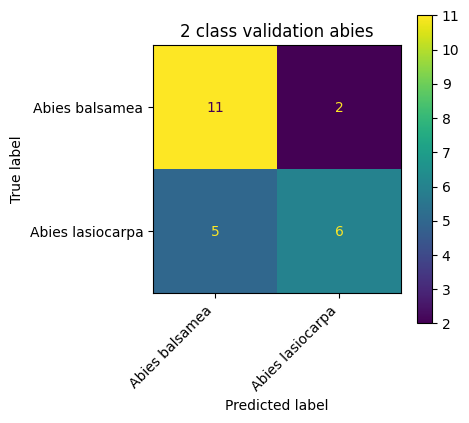

balanced_accuracy_score 0.7878754171301445


/Users/ariane/opt/miniconda3/envs/rhm/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


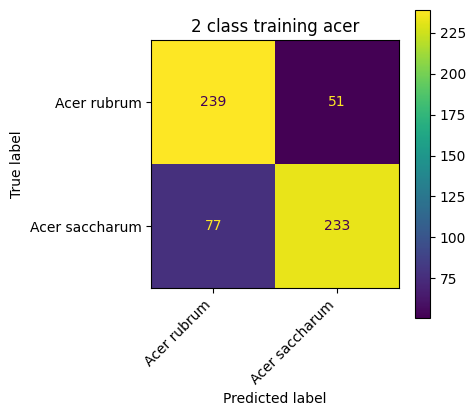

balanced_accuracy_score 0.39294117647058824


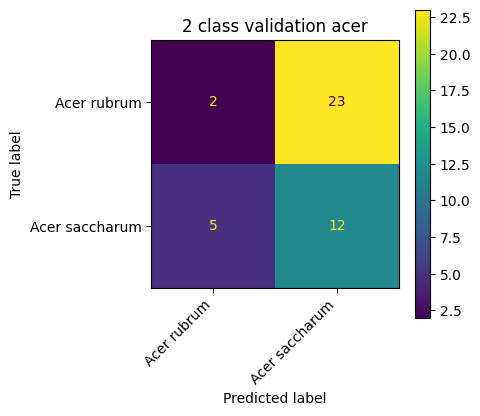

balanced_accuracy_score 0.8267154301637061


/Users/ariane/opt/miniconda3/envs/rhm/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


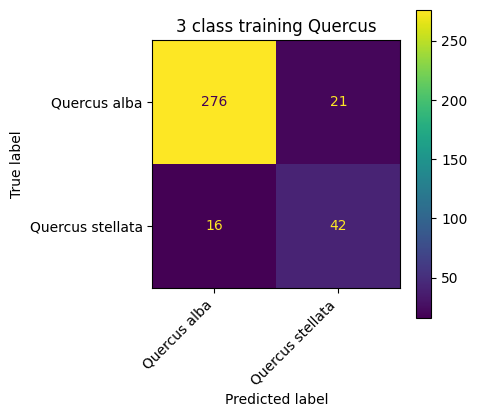

balanced_accuracy_score 0.5189393939393939


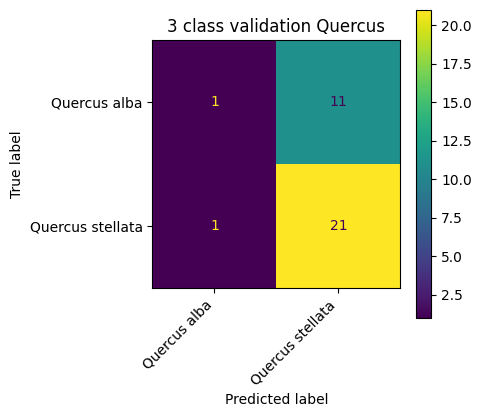

balanced_accuracy_score 0.9899665551839465


/Users/ariane/opt/miniconda3/envs/rhm/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


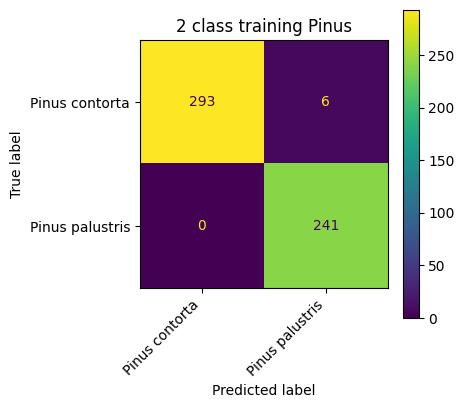

balanced_accuracy_score 0.5490384615384616


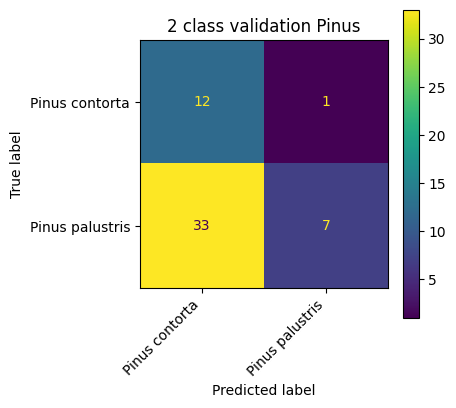

In [38]:
bands = [1, 2, 3, 4, 5, 6, 7, 8]
training_cols = [f'band_{i}' for i in bands] + ['nitian', 'ndvi', 'sr', 'tvi', 'gi', 'gndvi', 'pri', 'osavi', 'tcari', 'redge', 'redge2',
            'siredge', 'normg', 'schl', 'schlcar']

plt.rcParams["figure.figsize"] = (4,4)

# Run our tests! 
# ---------- 2 class problem with the largest classes in validation
test_species = ['Abies lasiocarpa', 'Abies balsamea']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training abies', clf_type='svm')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation abies')

# ---------- 2 class problem with imbalance
test_species = ['Acer rubrum', 'Acer saccharum']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training acer', clf_type='svm')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation acer')

# ---------- 3 class problem
test_species = ['Quercus stellata', 'Quercus alba', 'Quercus stellata']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='3 class training Quercus', clf_type='svm')
clf = classify(valid_df, training_cols, clf=clf, label='3 class validation Quercus')

# ---------- 2 class problem
test_species = ['Pinus palustris', 'Pinus contorta']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training Pinus', clf_type='svm')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation Pinus')


balanced_accuracy_score 0.9641439105420955


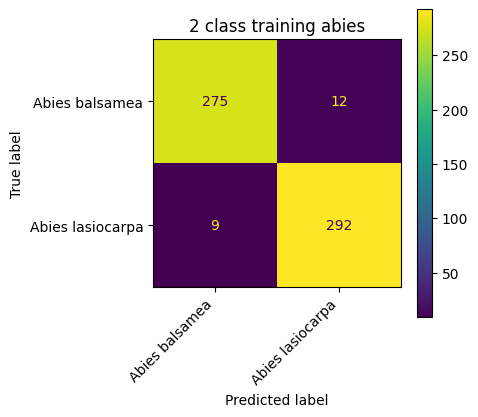

balanced_accuracy_score 0.6433566433566433


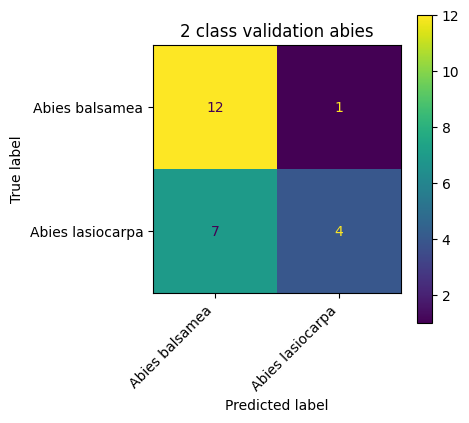

balanced_accuracy_score 0.9078420467185762


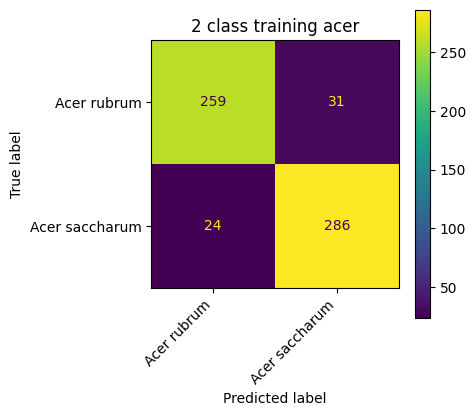

balanced_accuracy_score 0.5


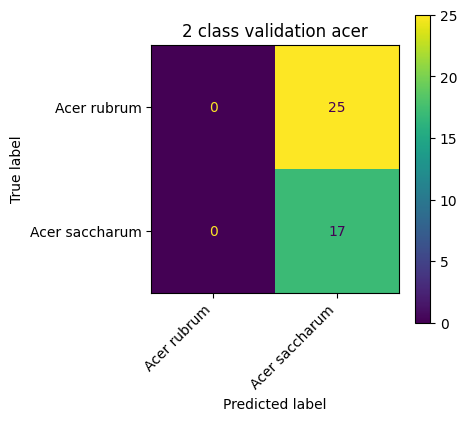

balanced_accuracy_score 0.8069778242192036


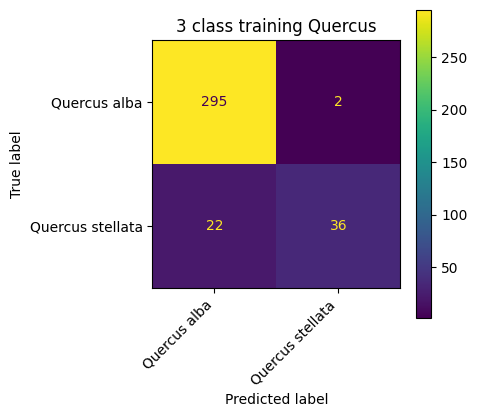

balanced_accuracy_score 0.4962121212121212


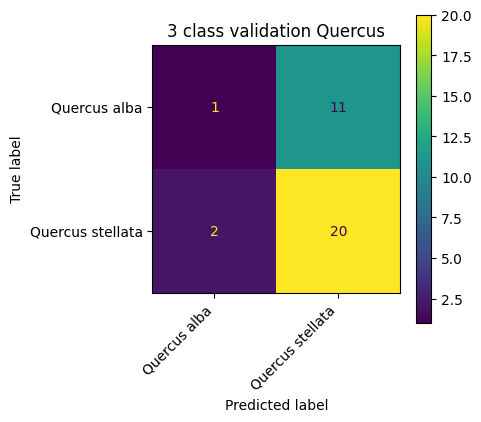

balanced_accuracy_score 0.9962530704006439


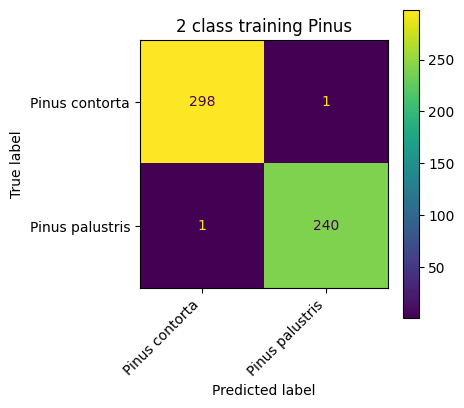

balanced_accuracy_score 0.525


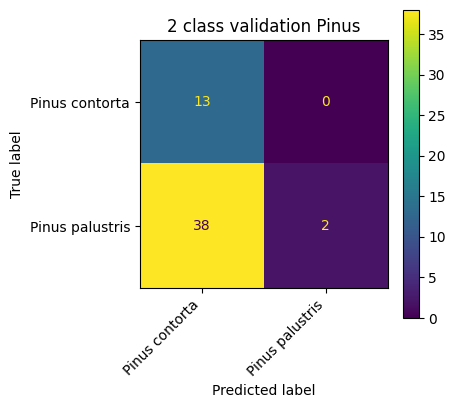

In [39]:
bands = [1, 2, 3, 4, 5, 6, 7, 8]
training_cols = [f'band_{i}' for i in bands] + ['nitian', 'ndvi', 'sr', 'tvi', 'gi', 'gndvi', 'pri', 'osavi', 'tcari', 'redge', 'redge2',
            'siredge', 'normg', 'schl', 'schlcar']

plt.rcParams["figure.figsize"] = (4,4)

# Run our tests! 
# ---------- 2 class problem with the largest classes in validation
test_species = ['Abies lasiocarpa', 'Abies balsamea']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training abies')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation abies')

# ---------- 2 class problem with imbalance
test_species = ['Acer rubrum', 'Acer saccharum']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training acer')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation acer')

# ---------- 3 class problem
test_species = ['Quercus stellata', 'Quercus alba', 'Quercus stellata']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='3 class training Quercus')
clf = classify(valid_df, training_cols, clf=clf, label='3 class validation Quercus')

# ---------- 2 class problem
test_species = ['Pinus palustris', 'Pinus contorta']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training Pinus')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation Pinus')
